In [1]:
from lanlab import Text,Batch,Sequential,Sequence
from lanlab import load,save
from lanlab import set_number_workers

import matplotlib.patheffects as pe
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import torch
import os

set_number_workers(5) #Set the number of workers to 5 to generate the data faster

/Users/nyax/Documents/git/PhyloLM/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Paper's configuration
nb_genes = 2048*2
genes_depth = 16
nb_probes = 64*2
prefix = None

FOLDER_PATH = 'codef'

In [3]:
#Generate text
def generate_genes(models,prefix=None,genes_depth=16,nb_genes=64):
    #Start from an empty batch
    genes_batch = Batch((nb_genes,))
    for i in range(nb_genes):
        #sample one model from the models
        model = np.random.choice(models)
        generate_pipeline = Sequential(model.configure(max_tokens=genes_depth,logit_bias={'50256':-100}))
        #Generate the prefix
        genes_batch[i] = generate_pipeline(Sequence(l=[]),os.path.join('data','kl_pop',FOLDER_PATH,'genes',str(i)))
    return genes_batch

In [4]:
#For each model in models generate nb_probes completions of 1 token to each prefix
def compute_probes(models,genes_batch,nb_char=1):
    #Start from an empty batch
    probes = np.zeros((nb_genes,len(models),nb_probes),dtype=object)
    for k in range(nb_probes):
        for j,m in enumerate(models):
            print('Generating probe '+str(k)+' for model '+m.name)
            generate_pipeline = Sequential(m.configure(max_tokens=5))#,logit_bias={'50256':-100}))
            #Generate the prefix
            batch = generate_pipeline(genes_batch,os.path.join('data','kl_pop',FOLDER_PATH,'probes_batch',m.name,str(k)))
    #Extract the last token of each probe
    
            for i in range(nb_genes):
                probes[i,j,k] = batch[i][-1]['text'] #Get the only token of the last segment
                if not(nb_char is None):
                    probes[i,j,k] = probes[i,j,k].lstrip(' ').lstrip('\n')[:nb_char] #Get the first character of the token
    return probes
def compute_probas(probes,genes_index=None,probes_index=None):
    nb_genes,nb_models,nb_probes = probes.shape
    #Count the multiplicity of each probe
    ld = [[{} for _ in range(nb_models)] for _ in range(nb_genes)]
    for i in genes_index:
        for j in range(nb_models):
            for k in probes_index:
                ld[i][j][probes[i,j,k]] = ld[i][j].get(probes[i,j,k],0)+1
    #Normalize the multiplicity of each probe to get probabilities
    for i in genes_index:
        for j in range(nb_models):
            for k in ld[i][j]:
                ld[i][j][k] /= nb_probes
    return ld

In [5]:
def match(d,k):
    if k in d:
        return d[k]
    else:
        return 0

def compute_nei(ld,models,subset_genes=None):
    #Estimate the nei similarity between each couple of models
    kl = np.zeros((len(models),len(models)))
    for i in range(len(models)):
        for j in range(len(models)):
            #Compute nei score instead of kl divergence
            up = 0
            dleft = 0
            dright = 0
            genes = range(len(ld)) if subset_genes is None else subset_genes
            for k in genes:
                for l in {**ld[k][i],**ld[k][j]}:
                    up += match(ld[k][i],l)*match(ld[k][j],l)
                for l in ld[k][i]:
                    dleft += ld[k][i][l]**2
                for l in ld[k][j]:
                    dright += ld[k][j][l]**2
            kl[i,j] = up/(dleft*dright)**0.5
    return kl

In [6]:
#Generate array
from lanlab.core.module.models import *
models = [AD(),BB(),TAD1(),TBB1(),BB2()]

import logging
#logging.basicConfig(level=logging.INFO)

#Load the genes (and not generate them as they already exist)
genes_batch = generate_genes(models,prefix=prefix,genes_depth=genes_depth,nb_genes=nb_genes)


In [7]:
probes = compute_probes(models,genes_batch,nb_char=4)

Generating probe 0 for model AD
Generating probe 0 for model BB
Generating probe 0 for model TAD1
Generating probe 0 for model TBB1
Generating probe 0 for model BB2
Generating probe 1 for model AD
Generating probe 1 for model BB
Generating probe 1 for model TAD1
Generating probe 1 for model TBB1
Generating probe 1 for model BB2
Generating probe 2 for model AD
Generating probe 2 for model BB
Generating probe 2 for model TAD1
Generating probe 2 for model TBB1
Generating probe 2 for model BB2
Generating probe 3 for model AD
Generating probe 3 for model BB
Generating probe 3 for model TAD1
Generating probe 3 for model TBB1
Generating probe 3 for model BB2
Generating probe 4 for model AD
Generating probe 4 for model BB
Generating probe 4 for model TAD1
Generating probe 4 for model TBB1
Generating probe 4 for model BB2
Generating probe 5 for model AD
Generating probe 5 for model BB
Generating probe 5 for model TAD1
Generating probe 5 for model TBB1
Generating probe 5 for model BB2
Generating

In [12]:
#Plot distance matrix
import matplotlib.pyplot as plt
def plot_distance_matrix(data,labels,vmin=None,vmax=None,title=None,show=True,figsize=(10,10)):
    fig, ax = plt.subplots(figsize=figsize)
    cm = plt.get_cmap('gray')
    #cm = plt.cm.get_cmap('gray')
    cm.set_bad('Black')
    im = ax.imshow(data,cmap=cm,vmin=vmin,vmax=vmax,interpolation='nearest')

    #Put names as axis labels
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(reversed(labels))

    ax.set_xlabel('X')
    ax.set_ylabel('Y')

    #Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right",rotation_mode="anchor")

    plt.colorbar(im)
    plt.title(title)
    if show:
        plt.show()

### Analyses Stats

In [13]:
#Distance metric
def distance(m1,m2):
    return np.sum((m1-m2)**2)

#Get the similarity matrix
def get_matrix(genes_index,probes_index):
    ld = compute_probas(probes,genes_index=genes_index,probes_index=probes_index)
    kl_mean = compute_nei(ld,models)
    return kl_mean

#Split the genes in 8 stacks
def generate_split(nb_max,inter):
    l = []
    index = 0
    while True:
        new_range = range(index,min(index+inter,nb_max))
        l.append(new_range)
        index =min(index+inter,nb_max)
        if index==nb_max:
            return l[:8]

#Get the stacked matrix
def get_stacked_matrix(genes_indexs,probes_indexs):
    d = np.zeros((len(genes_indexs),len(models),len(models)))
    for i,(genes_index,probes_index) in enumerate(zip(genes_indexs,probes_indexs)):
        d[i] = get_matrix(genes_index,probes_index)
    return d

#Compute the optimal matrix on the second half of the set of genes
optimal_matrix = get_matrix(range(2048,nb_genes),range(nb_probes))
def get_oracle_stats(genes_size,probes_size):
    #Pick genes on the first half of the set of genes
    genes_stacks = generate_split(2048,genes_size)
    #Pick probes for each stack
    probes_stacks = [range(probes_size) for _ in range(len(genes_stacks))]
    #Get data
    stacked_matrix = get_stacked_matrix(genes_stacks,probes_stacks)
    #Get variance
    variance_stacked_matrix = (stacked_matrix-optimal_matrix[None,:,:])**2
    variance_matrix = variance_stacked_matrix.mean(axis=2).mean(axis=1)**0.5
    return variance_matrix.mean(),variance_matrix.std()

#Compute the variance matrix
def get_variance_stats(genes_size,probes_size):
    #Pick genes
    genes_stacks = generate_split(2048,genes_size)
    #Pick probes for each stack
    probes_stacks = [range(probes_size) for _ in range(len(genes_stacks))]
    #Get data
    stacked_matrix = get_stacked_matrix(genes_stacks,probes_stacks)
    #Get variance
    variance_stacked_matrix = (stacked_matrix-stacked_matrix.mean(axis=0))**2
    variance_matrix = variance_stacked_matrix.mean(axis=2).mean(axis=1)**0.5
    return variance_matrix.mean(),variance_matrix.std()

In [14]:
#Useful functions
matplotlib.colors.to_rgb = matplotlib.colors.ColorConverter().to_rgb
matplotlib.colors.to_rgba = matplotlib.colors.ColorConverter().to_rgba
matplotlib.colors.to_rgba_array = matplotlib.colors.ColorConverter().to_rgba_array

#### Plot a few matrices

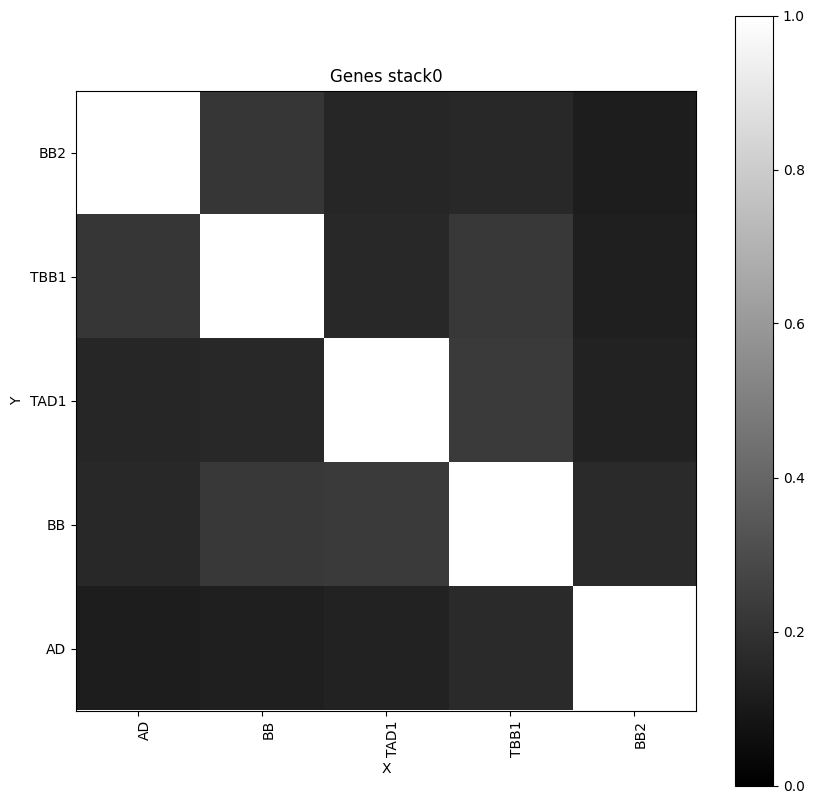

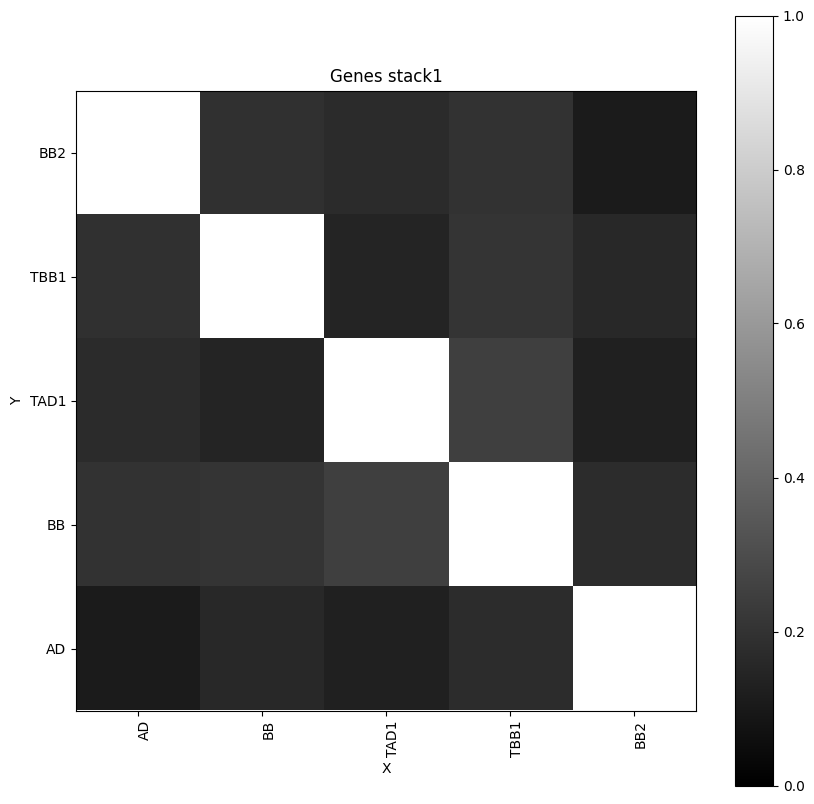

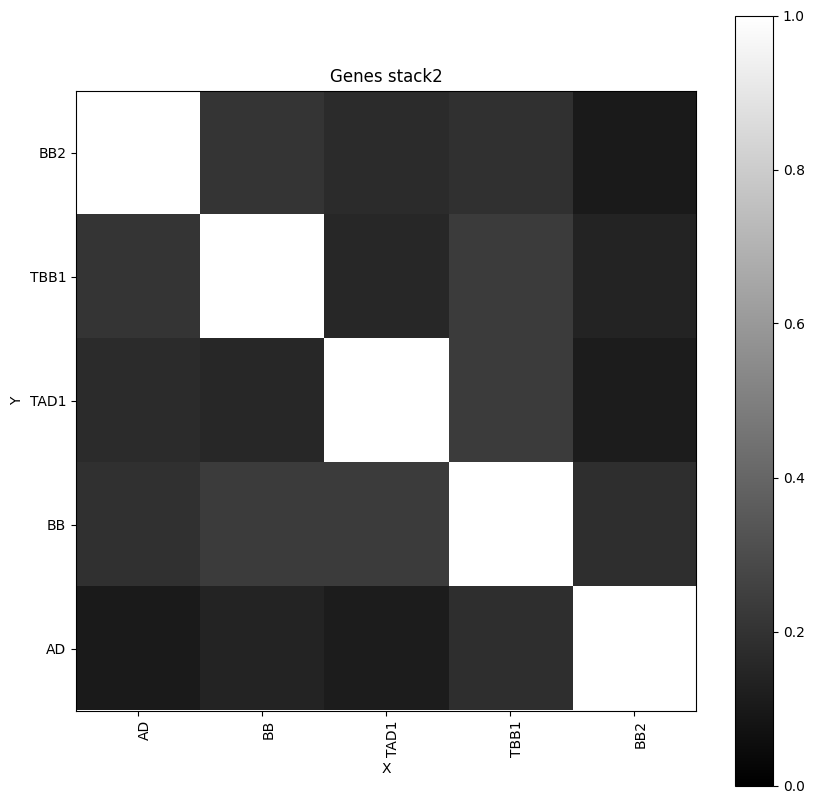

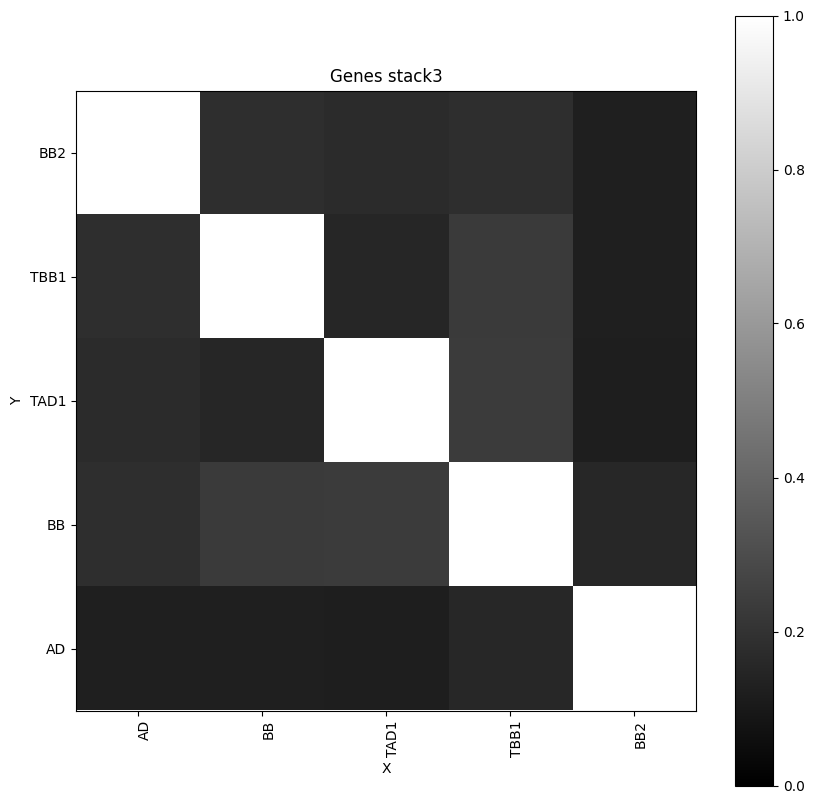

In [15]:
genes_size = 512
probes_size = 1

genes_stacks = generate_split(2048,genes_size)
probes_stacks = [range(probes_size) for _ in range(len(genes_stacks))]
stacked_matrix = get_stacked_matrix(genes_stacks,probes_stacks)

#Plot each matrix in a compact format
for i in range(stacked_matrix.shape[0]):
    plot_distance_matrix(stacked_matrix[i],labels=[m.name for m in models],vmin=0,vmax=1,title='Genes stack'+str(i))

In [16]:
#Variability analysis
analysis = 'variance'
size_genes = [16,32,64,128,256] #G values
size_probes = [8,16,32,64,128] #N values
#For each combination of G and N, compute the mean and standard deviation of the distance matrix
distances_mean = np.zeros((len(size_genes),len(size_probes)))
distances_stderr = np.zeros((len(size_genes),len(size_probes)))
for i,inter_genes in enumerate(size_genes):
    for j,inter_probes in enumerate(size_probes):
        if analysis == 'variance':
            mean,std =get_variance_stats(inter_genes,inter_probes)
        elif analysis == 'oracle':
            mean,std =get_oracle_stats(inter_genes,inter_probes)
        distances_mean[i,j] = mean
        distances_stderr[i,j] = std/len(genes_stacks)**0.5

In [17]:
#Plot the distance_std matrix
#Plot KL
import matplotlib.pyplot as plt
def plot_std_matrix(data,xlabels,ylabels,vmin=None,vmax=None,title=None,show=True,figsize=(10,10)):
    fig, ax = plt.subplots(figsize=figsize)
    cm = plt.cm.get_cmap('Greys')
    cm.set_bad('Black')
    im = ax.imshow(data.transpose(),cmap=cm,vmin=vmin,vmax=vmax)

    #Put names as axis labels
    ax.set_xticks(np.arange(len(xlabels)))
    ax.set_yticks(np.arange(len(ylabels)))
    ax.set_xticklabels(xlabels)
    ax.set_yticklabels(ylabels)

    ax.set_xlabel('G')
    ax.set_ylabel('N')

    #Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right",rotation_mode="anchor")

    plt.colorbar(im)
    plt.title(title)
    if show:
        plt.show()

def plot_evol(data,stderr,xlabels,ylabels,vmin=None,vmax=None,show=True,figsize=(10,10),colors=None):
    #Plot the evolution of the variance with G and N
    plt.rcParams.update({'font.size': 35})
    fig,ax = plt.subplots(figsize=figsize)
    for i in range(data.shape[1]):
        ax.errorbar(xlabels,data[:,i],yerr=stderr[:,i],label=ylabels[i],color=colors[i] if colors is not None else None,lw=5)
    ax.legend()
    plt.xlabel('G')
    plt.ylabel('Variance')
    #Truncate yticklabels
    yticks = ax.get_yticks()
    ax.set_yticks(yticks[::2])
    ax.set_yticklabels([str(y)[:4] for y in yticks[::2]])
    #Add legend title
    ax.legend(title='N')
    if show:
        plt.show()

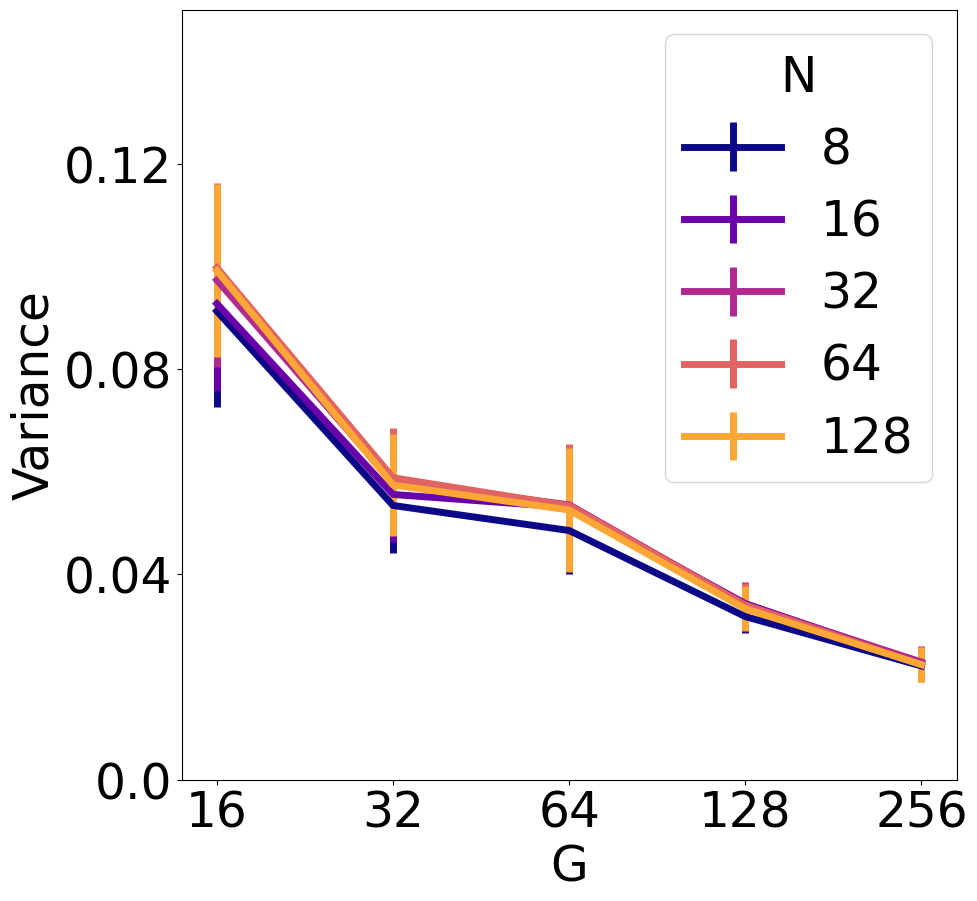

In [19]:
#Colors are a a gradient from a pretty colormap
cm = plt.get_cmap('plasma')
#cm = plt.cm.get_cmap('plasma')
plot_evol(distances_mean,distances_stderr,xlabels=[str(i) for i in size_genes],ylabels=[str(i) for i in size_probes],vmin=0,vmax=None,colors=[cm(i/len(size_probes)) for i in range(len(size_probes))],show=False)
plt.ylim(0,0.15)
plt.savefig(FOLDER_PATH+'_hyper_'+analysis+'.svg',bbox_inches='tight',format='svg')

In [20]:
# Distance to high precision matrix
analysis = 'oracle'
size_genes = [16,32,64,128,256]
size_probes = [8,16,32,64,128]
#For each combination of G and N, compute the mean and standard deviation of the distance matrix
distances_mean = np.zeros((len(size_genes),len(size_probes)))
distances_stderr = np.zeros((len(size_genes),len(size_probes)))
for i,inter_genes in enumerate(size_genes):
    for j,inter_probes in enumerate(size_probes):
        if analysis == 'variance':
            mean,std =get_variance_stats(inter_genes,inter_probes)
        elif analysis == 'oracle':
            mean,std =get_oracle_stats(inter_genes,inter_probes)
        distances_mean[i,j] = mean
        distances_stderr[i,j] = std/len(genes_stacks)**0.5

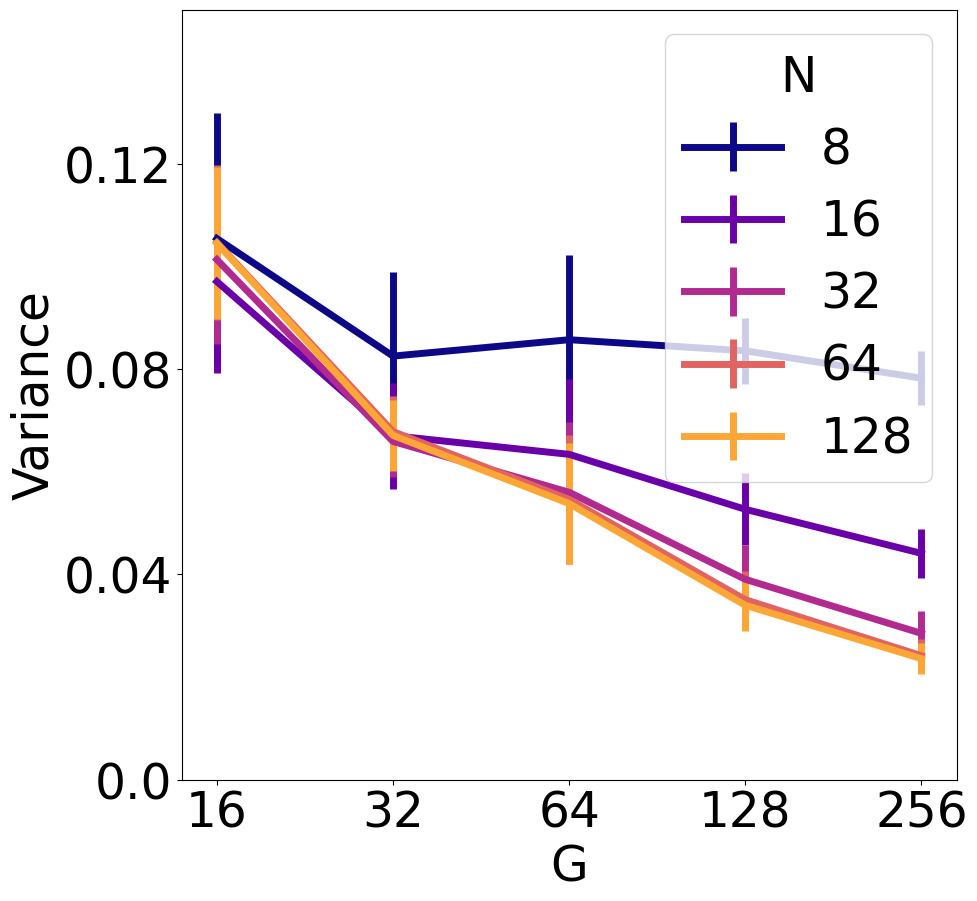

In [21]:
#Colors are a a gradient from a pretty colormap
cm = plt.get_cmap('plasma')
#cm = plt.cm.get_cmap('plasma')
plot_evol(distances_mean,distances_stderr,xlabels=[str(i) for i in size_genes],ylabels=[str(i) for i in size_probes],vmin=0,vmax=None,colors=[cm(i/len(size_probes)) for i in range(len(size_probes))],show=False)
plt.ylim(0,0.15)
plt.savefig(FOLDER_PATH+'_hyper_'+analysis+'.svg',bbox_inches='tight',format='svg')